## Import required modules


In [1]:
from typing import List, Tuple
from pathlib import Path
import os

import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import (
    RandomizedSearchCV,
    validation_curve,
    TimeSeriesSplit,
)
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.model_selection import GridSearchCV

sns.set_theme()

In [2]:
# Initialize file paths / constants
yfin_data_dir = os.path.join(Path().cwd(), "yfin_data")
yfin_data_dir

'/Users/weiming/Dev/Projects/ml-ta-forecast/yfin_data'

## Helper Functions


In [3]:
def plot_chart_sma(
    input_df: pd.DataFrame,
    ticker: str,
    start_dte: str,
    end_dte: str,
    slow: int,
    fast: int,
):
    df = input_df.copy()
    start = dt.datetime.strptime(start_dte, "%Y-%m-%d")
    end = dt.datetime.strptime(end_dte, "%Y-%m-%d")

    fig = plt.figure(facecolor="white", figsize=(20, 10))

    ax0 = plt.subplot2grid((6, 4), (1, 0), rowspan=4, colspan=4)
    ax0.plot(
        df[df["symbol"] == ticker].loc[
            start:end, ["Close", f"SMA_{fast}", f"SMA_{slow}"]
        ]
    )
    # ax0.set_facecolor("black")
    ax0.legend(
        ["Close", f"SMA_{fast}", f"SMA_{slow}"], ncol=3, loc="upper left", fontsize=15
    )
    plt.title(f"{ticker} Stock Price, Slow and Fast Moving Average", fontsize=20)

    ax1 = plt.subplot2grid((6, 4), (5, 0), rowspan=1, colspan=4, sharex=ax0)
    ax1.plot(df[df["symbol"] == ticker].loc[start:end, ["SMA_ratio"]], color="blue")
    ax1.legend(["SMA_Ratio"], ncol=3, loc="upper left", fontsize=12)
    ax1.set_facecolor("silver")
    plt.subplots_adjust(
        left=0.09, bottom=0.09, right=1, top=0.95, wspace=0.20, hspace=0
    )
    plt.show()

## Import / Load Data


In [4]:
# Obtain list of SPY companies


def get_tickers(url: str) -> List[str]:
    """
    Generates the list of tickers from provided URL

    Args:
        url (str): URL containing tickers (wikipedia)

    Returns:
        List[str]: List of tickers in S&P 500
    """

    r = requests.get(url)
    soup = BeautifulSoup(r.text, "lxml")
    table = soup.find("table", {"class": "wikitable sortable"})

    tickers = []

    for rows in table.find_all("tr")[1:]:
        ticker = rows.find_all("td")[0].text.strip()
        tickers.append(ticker)

    return tickers


tickers = get_tickers("https://en.wikipedia.org/wiki/S%26P_100")
print(tickers)

['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN', 'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK.B', 'C', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'DE', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'F', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'JNJ', 'JPM', 'KHC', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'MET', 'META', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTX', 'SBUX', 'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT', 'XOM']


In [5]:
def get_yfin_data(
    tickers: List[str], start_dte: str, end_dte: str
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """
    Retrieves stock data from Yahoo Finance
    - High
    - Low
    - Open
    - Close
    - Volume
    - AdjClose

    Args:
        tickers (List[str]): List of tickers to retrieve data
        start_dte (str): YYYY-MM-DD
        end_dte (str): YYYY-MM-DD

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, List[str]]: _description_
    """
    all_data = pd.DataFrame()
    test_data = pd.DataFrame()
    no_data = []

    for ticker in tickers:
        try:

            # Check if data is present, else download data
            if f"{ticker}.csv" in os.listdir(yfin_data_dir):
                print(f"Ticker data found for: {ticker}")
                test_data = pd.read_csv(
                    os.path.join(yfin_data_dir, f"{ticker}.csv"),
                    index_col=0,
                    parse_dates=True,
                )
            else:
                print(f"Downloading data for: {ticker}")
                test_data = yf.download(ticker, start=start_dte, end=end_dte)
                test_data["symbol"] = ticker
                test_data.to_csv(os.path.join(yfin_data_dir, f"{ticker}.csv"))
            all_data = pd.concat([all_data, test_data])
        except:
            print(f"no data for: {ticker}")
            no_data.append(ticker)
        # clear_output(wait = True)

    return all_data, test_data, no_data


all_data, test_data, no_data = get_yfin_data(
    tickers, "1990-01-01", dt.datetime.today().strftime("%Y-%m-%d")
)

Ticker data found for: AAPL
Ticker data found for: ABBV
Ticker data found for: ABT
Ticker data found for: ACN
Ticker data found for: ADBE
Ticker data found for: AIG
Ticker data found for: AMD
Ticker data found for: AMGN
Ticker data found for: AMT
Ticker data found for: AMZN
Ticker data found for: AVGO
Ticker data found for: AXP
Ticker data found for: BA
Ticker data found for: BAC
Ticker data found for: BK
Ticker data found for: BKNG
Ticker data found for: BLK
Ticker data found for: BMY
Ticker data found for: BRK.B
Ticker data found for: C
Ticker data found for: CAT
Ticker data found for: CHTR
Ticker data found for: CL
Ticker data found for: CMCSA
Ticker data found for: COF


/var/folders/5_/5031yk8j46l_7pk431n48pyw0000gn/T/ipykernel_72381/2283183043.py:41: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_data = pd.concat([all_data, test_data])
/var/folders/5_/5031yk8j46l_7pk431n48pyw0000gn/T/ipykernel_72381/2283183043.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, test_data])


Ticker data found for: COP
Ticker data found for: COST
Ticker data found for: CRM
Ticker data found for: CSCO
Ticker data found for: CVS
Ticker data found for: CVX
Ticker data found for: DE
Ticker data found for: DHR
Ticker data found for: DIS
Ticker data found for: DOW
Ticker data found for: DUK
Ticker data found for: EMR
Ticker data found for: F
Ticker data found for: FDX
Ticker data found for: GD
Ticker data found for: GE
Ticker data found for: GILD
Ticker data found for: GM
Ticker data found for: GOOG
Ticker data found for: GOOGL
Ticker data found for: GS
Ticker data found for: HD
Ticker data found for: HON
Ticker data found for: IBM
Ticker data found for: INTC
Ticker data found for: INTU
Ticker data found for: JNJ
Ticker data found for: JPM
Ticker data found for: KHC
Ticker data found for: KO
Ticker data found for: LIN
Ticker data found for: LLY
Ticker data found for: LMT
Ticker data found for: LOW
Ticker data found for: MA
Ticker data found for: MCD
Ticker data found for: MDLZ
Ti

In [6]:
# Preview loaded data
all_data

,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL
...,...,...,...,...,...,...,...
2024-06-12,113.300003,113.300003,110.540001,110.930000,110.930000,13606800,XOM
2024-06-13,110.839996,110.860001,109.720001,110.040001,110.040001,14466900,XOM
2024-06-14,110.019997,110.209999,108.589996,109.110001,109.110001,13313400,XOM


## Generate Technical Indicators


### Simple Moving Average


In [25]:
def sma(stocks_data: pd.DataFrame, slow: int = 15, fast: int = 5) -> pd.DataFrame:
    """
    Generates simple moving average technical indiacator

    Args:
        stocks_data (pd.DataFrame): Input data using Close Data
        slow (int, optional): slower moving average window. Defaults to 15.
        fast (int, optional): faster moving average window. Defaults to 5.

    Returns:
        pd.DataFrame: _description_
    """

    data = stocks_data.copy()
    data[f"SMA_{fast}"] = data.groupby("symbol")["Close"].transform(
        lambda x: x.rolling(window=fast).mean()
    )
    data[f"SMA_{slow}"] = data.groupby("symbol")["Close"].transform(
        lambda x: x.rolling(window=slow).mean()
    )
    data["SMA_ratio"] = data[f"SMA_{slow}"] / data[f"SMA_{fast}"]
    print(type(data))

    return data


all_data = sma(all_data)
all_data.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,rsi_15,RSI_Ratio,12Ewm,26Ewm,MACD,20_MA,20_SD,bollinger_upper,bollinger_lower,RC
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN,...,NaN,NaN,0.332589,0.332589,0.000000,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN,...,NaN,NaN,0.332932,0.332754,-0.000178,NaN,NaN,NaN,NaN,NaN
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN,...,NaN,NaN,0.333395,0.332990,-0.000405,NaN,NaN,NaN,NaN,NaN
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN,...,NaN,NaN,0.333958,0.333291,-0.000667,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN,...,NaN,NaN,0.334777,0.333735,-0.001042,NaN,NaN,NaN,NaN,NaN


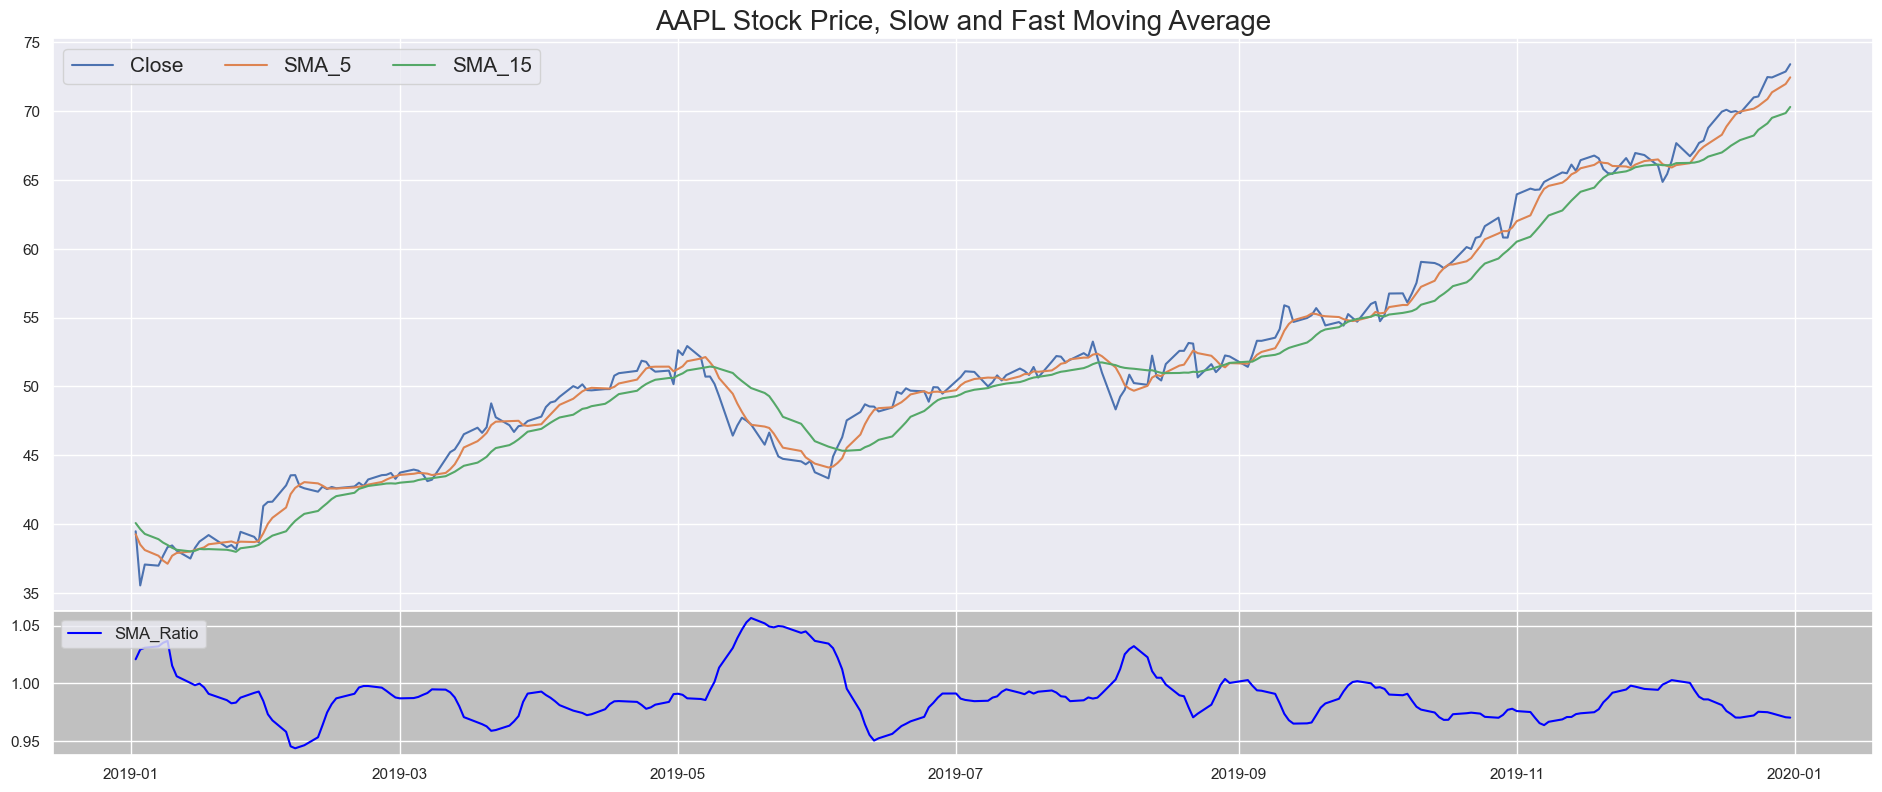

In [8]:
plot_chart_sma(all_data, "AAPL", "2019-01-01", "2020-01-01", 15, 5)

### Simple Moving Average Volume


In [9]:
def sma_vol(stocks_data: pd.DataFrame, slow: int = 15, fast: int = 5) -> pd.DataFrame:

    df = stocks_data.copy()
    df[f"SMA_{fast}_Volume"] = df.groupby("symbol")["Volume"].transform(
        lambda x: x.rolling(window=fast).mean()
    )
    df[f"SMA_{slow}_Volume"] = df.groupby("symbol")["Volume"].transform(
        lambda x: x.rolling(window=slow).mean()
    )
    df["SMA_Volume_Ratio"] = df[f"SMA_{fast}_Volume"] / df[f"SMA_{slow}_Volume"]

    return df


all_data = sma_vol(all_data)

In [10]:
all_data

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,SMA_5_Volume,SMA_15_Volume,SMA_Volume_Ratio
Date,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN,167518400.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-12,113.300003,113.300003,110.540001,110.930000,110.930000,13606800,XOM,112.580000,113.686000,1.009824,13551540.0,1.595353e+07,0.849439
2024-06-13,110.839996,110.860001,109.720001,110.040001,110.040001,14466900,XOM,111.794000,113.323333,1.013680,13814100.0,1.572603e+07,0.878422
2024-06-14,110.019997,110.209999,108.589996,109.110001,109.110001,13313400,XOM,111.066000,113.030000,1.017683,13818940.0,1.554827e+07,0.888777


### Wilder's Smoothing


In [11]:
def wilder_smoothing(input_df: pd.DataFrame, periods) -> pd.DataFrame:
    df = input_df.copy()
    start = np.where(~np.isnan(df))[0][0]  # Check if np.nan is present in beginning
    wilder = np.array([np.nan] * len(df))
    wilder[start + periods - 1] = df[start : (start + periods)].mean()  # SMA
    for i in range(start + periods, len(df)):
        wilder[i] = (
            wilder[i - 1] * (periods - 1) + df[i]
        ) / periods  # wilder smoothing
    return wilder

### Average True Range


In [12]:
def atr(stocks_data: pd.DataFrame, slow:int, fast:int)->pd.DataFrame:
    df = stocks_data.copy()
    df["prev_close"] = df.groupby("symbol")["Close"].shift(1)
    df["TR"] = np.maximum((df["High"] - df["Low"]), np.maximum(abs(df["High"] - df["prev_close"]), abs(df["prev_close"] - df["Low"])))
    
    for symbol in df["symbol"].unique():
        tr_data = df[df["symbol"] == symbol].copy()
        df.loc[df["symbol"] == symbol, f"ATR_{fast}"] = wilder_smoothing(df["TR"], fast)
        df.loc[df["symbol"] == symbol, f"ATR_{slow}"] = wilder_smoothing(df["TR"], slow)

    df["ATR_Ratio"] = df[f"ATR_{fast}"] / df[f"ATR_{slow}"]
    
    return df

### Stochastic Oscillators


In [32]:
def stochastic_osc(stock_data:pd.DataFrame, slow:int = 15, fast:int = 5)->pd.DataFrame:
    
    df = stock_data.copy()
    df[f"Lowest_{fast}D"] = df.groupby("symbol")["Low"].transform(lambda x: x.rolling(window=fast).min())
    df[f"High_{fast}D"] = df.groupby("symbol")["High"].transform(lambda x: x.rolling(window=fast).max())
    
    df[f"Lowest_{slow}D"] = df.groupby("symbol")["Low"].transform(lambda x: x.rolling(window=slow).min())
    df[f"High_{slow}D"] = df.groupby("symbol")["High"].transform(lambda x: x.rolling(window=slow).max())
    
    df[f"Stochastic_{fast}"] = ((df["Close"] - df[f"Lowest_{fast}D"]) / (df[f"High_{fast}D"] - df[f"Lowest_{fast}D"])) * 100
    df[f"Stochastic_{slow}"] = ((df["Close"] - df[f"Lowest_{slow}D"]) / (df[f"High_{slow}D"] - df[f"Lowest_{slow}D"])) * 100
    
    df[f"Stochastic_%D_{fast}"] = df[f"Stochastic_{fast}"].rolling(window=fast).mean()
    df[f"Stochastic_%D_{slow}"] = df[f"Stochastic_{slow}"].rolling(window=slow).mean()
    
    df["Stochastic_Ratio"] = df[f"Stochastic_%D_{fast}"] / df[f"Stochastic_%D_{slow}"]
    
    return df

In [34]:
all_data = stochastic_osc(all_data)
all_data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,Target_Direction,Lowest_5D,High_5D,Lowest_15D,High_15D,Stochastic_5,Stochastic_15,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-29,0.294643,0.299107,0.286830,0.296875,0.234828,119929600,AAPL,0.299777,0.305209,1.018119,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-30,0.296875,0.308036,0.294643,0.303571,0.240125,116446400,AAPL,0.300223,0.303051,1.009418,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-31,0.308036,0.310268,0.294643,0.303571,0.240125,143942400,AAPL,0.300223,0.301860,1.005453,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-01,0.308036,0.309152,0.299107,0.300223,0.237476,117073600,AAPL,0.299330,0.301339,1.006712,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-02,0.296875,0.310268,0.296875,0.305804,0.241891,118473600,AAPL,0.302009,0.301191,0.997291,...,1,0.28683,0.310268,NaN,NaN,80.95401,NaN,NaN,NaN,NaN


In [36]:
all_data.head(30)

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,Target_Direction,Lowest_5D,High_5D,Lowest_15D,High_15D,Stochastic_5,Stochastic_15,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-29,0.294643,0.299107,0.286830,0.296875,0.234828,119929600,AAPL,0.299777,0.305209,1.018119,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-30,0.296875,0.308036,0.294643,0.303571,0.240125,116446400,AAPL,0.300223,0.303051,1.009418,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-31,0.308036,0.310268,0.294643,0.303571,0.240125,143942400,AAPL,0.300223,0.301860,1.005453,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-01,0.308036,0.309152,0.299107,0.300223,0.237476,117073600,AAPL,0.299330,0.301339,1.006712,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-02,0.296875,0.310268,0.296875,0.305804,0.241891,118473600,AAPL,0.302009,0.301191,0.997291,...,1,0.286830,0.310268,NaN,NaN,80.954010,NaN,NaN,NaN,NaN
1990-02-05,0.305804,0.314732,0.303571,0.312500,0.247187,101752000,AAPL,0.305134,0.301637,0.988540,...,0,0.294643,0.314732,NaN,NaN,88.889499,NaN,NaN,NaN,NaN
1990-02-06,0.310268,0.312500,0.303571,0.310268,0.245422,73920000,AAPL,0.306473,0.301563,0.983977,...,1,0.294643,0.314732,NaN,NaN,77.778998,NaN,NaN,NaN,NaN
1990-02-07,0.294643,0.303571,0.290179,0.296875,0.234828,312446400,AAPL,0.305134,0.301563,0.988295,...,1,0.290179,0.314732,NaN,NaN,27.271591,NaN,NaN,NaN,NaN
1990-02-08,0.296875,0.299107,0.287946,0.294643,0.233063,186636800,AAPL,0.304018,0.301935,0.993147,...,0,0.287946,0.314732,NaN,NaN,25.001975,NaN,59.979214,NaN,NaN


### Relative Strength Index (RSI)


In [13]:
def rsi(stocks_data:pd.DataFrame, slow:int = 15, fast:int = 5)->pd.DataFrame:
    """
    Generates RSI indicator based on specified fast and slow windows

    Args:
        stocks_data (pd.DataFrame): 
        slow (int): _description_
        fast (int): _description_

    Returns:
        pd.DataFrame: _description_
    """
    df = stocks_data.copy()
    df["diff"] = df.groupby("symbol")["Close"].transform(lambda x: x.diff())
    df["up"] = df["diff"]
    df.loc[(df["up"] < 0), "up"] = 0
    
    df["down"] = df["diff"]
    df.loc[(df["down"] > 0), "diff"] = 0
    df["down"] = abs(df["down"])
    
    df[f"avg_{fast}up"] = df.groupby("symbol")["up"].transform(lambda x: x.rolling(window=fast).mean())
    df[f"avg_{fast}down"] = df.groupby("symbol")["down"].transform(lambda x: x.rolling(window=fast).mean())
    
    df[f"avg_{slow}up"] = df.groupby("symbol")["up"].transform(lambda x: x.rolling(window=slow).mean())
    df[f"avg_{slow}down"] = df.groupby("symbol")["down"].transform(lambda x: x.rolling(window=slow).mean())
    
    df[f"rs_{fast}"] = df[f"avg_{fast}up"] / df[f"avg_{fast}down"]
    df[f"rs_{slow}"] = df[f"avg_{slow}up"] / df[f"avg_{slow}down"]
    
    df[f"rsi_{fast}"] = 100 - (100 / (1 + df[f"rs_{fast}"]))
    df[f"rsi_{slow}"] = 100 - (100 / (1 + df[f"rs_{slow}"]))
    
    df["RSI_Ratio"] = df[f"rsi_{fast}"] / df[f"rsi_{slow}"]
    
    return df

all_data = rsi(all_data)
    

In [14]:
all_data

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,down,avg_5up,avg_5down,avg_15up,avg_15down,rs_5,rs_15,rsi_5,rsi_15,RSI_Ratio
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN,...,0.002232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN,...,0.001117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN,...,0.001116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN,...,0.002232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-12,113.300003,113.300003,110.540001,110.930000,110.930000,13606800,XOM,112.580000,113.686000,1.009824,...,1.239998,0.236000,0.910001,0.446667,1.354668,0.259341,0.329725,20.593361,24.796460,0.830496
2024-06-13,110.839996,110.860001,109.720001,110.040001,110.040001,14466900,XOM,111.794000,113.323333,1.013680,...,0.889999,0.066000,0.918001,0.446667,1.256002,0.071896,0.355626,6.707346,26.233367,0.255680
2024-06-14,110.019997,110.209999,108.589996,109.110001,109.110001,13313400,XOM,111.066000,113.030000,1.017683,...,0.930000,0.066000,0.860001,0.446667,1.186668,0.076745,0.376405,7.127462,27.346946,0.260631


### Moving Average Convergence Divergence (MACD)


In [15]:
def macd(stocks_data:pd.DataFrame, slow:int = 26, fast:int = 12)->pd.DataFrame:
    df = stocks_data.copy()
    
    df[f"{fast}Ewm"] = df.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=fast, adjust=False).mean())
    df[f"{slow}Ewm"] = df.groupby("symbol")["Close"].transform(lambda x: x.ewm(span=slow, adjust=False).mean())
    df["MACD"] = df[f"{slow}Ewm"] - df[f"{fast}Ewm"]
    
    return df

In [16]:
all_data = macd(all_data)
all_data.head()

In [17]:
all_data

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,avg_15up,avg_15down,rs_5,rs_15,rsi_5,rsi_15,RSI_Ratio,12Ewm,26Ewm,MACD
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332589,0.332589,0.000000
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332932,0.332754,-0.000178
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333395,0.332990,-0.000405
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333958,0.333291,-0.000667
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.334777,0.333735,-0.001042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-12,113.300003,113.300003,110.540001,110.930000,110.930000,13606800,XOM,112.580000,113.686000,1.009824,...,0.446667,1.354668,0.259341,0.329725,20.593361,24.796460,0.830496,113.438139,114.790552,1.352413
2024-06-13,110.839996,110.860001,109.720001,110.040001,110.040001,14466900,XOM,111.794000,113.323333,1.013680,...,0.446667,1.256002,0.071896,0.355626,6.707346,26.233367,0.255680,112.915349,114.438659,1.523311
2024-06-14,110.019997,110.209999,108.589996,109.110001,109.110001,13313400,XOM,111.066000,113.030000,1.017683,...,0.446667,1.186668,0.076745,0.376405,7.127462,27.346946,0.260631,112.329910,114.043944,1.714033


In [18]:
all_data.tail(20)

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,avg_15up,avg_15down,rs_5,rs_15,rsi_5,rsi_15,RSI_Ratio,12Ewm,26Ewm,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-21,118.400002,119.449997,117.779999,117.849998,117.849998,14495000,XOM,118.522000,117.462000,0.991057,...,0.395333,0.818667,0.517375,0.482899,34.096693,32.564528,1.047050,118.142286,117.845924,-0.296362
2024-05-22,117.459999,117.459999,114.959999,115.480003,115.480003,17879300,XOM,117.902000,117.425334,0.995957,...,0.395333,0.827333,0.266566,0.477841,21.046362,32.333705,0.650911,117.732704,117.670670,-0.062034
2024-05-23,115.599998,117.510002,113.360001,113.510002,113.510002,15979800,XOM,117.030000,117.243334,1.001823,...,0.381333,0.944667,0.224050,0.403670,18.304016,28.758177,0.636480,117.083057,117.362473,0.279415
2024-05-24,114.839996,115.080002,113.040001,113.419998,113.419998,12211400,XOM,115.786000,117.071334,1.011101,...,0.381333,0.934667,0.000000,0.407989,0.000000,28.976695,0.000000,116.519510,117.070438,0.550928
2024-05-28,113.519997,115.110001,113.070000,114.860001,114.860001,13978300,XOM,115.024001,116.945334,1.016704,...,0.427334,0.980667,0.215247,0.435758,17.712197,30.350381,0.583591,116.264201,116.906701,0.642501
2024-05-29,114.529999,114.550003,112.809998,113.629997,113.629997,13902000,XOM,114.180000,116.776000,1.022736,...,0.427334,1.024001,0.202817,0.417318,16.861838,29.444190,0.572671,115.858939,116.663983,0.805044
2024-05-30,113.269997,114.129997,112.959999,113.989998,113.989998,14692000,XOM,113.881999,116.632000,1.024148,...,0.451334,1.046667,0.353634,0.431210,26.124807,30.129058,0.867097,115.571409,116.465910,0.894500
2024-05-31,114.120003,117.489998,113.989998,117.260002,117.260002,29037400,XOM,114.631999,116.553334,1.016761,...,0.516667,1.112001,0.793427,0.464628,44.240817,31.723292,1.394585,115.831193,116.524731,0.693538
2024-06-03,116.300003,116.360001,113.760002,114.449997,114.449997,19589300,XOM,114.837999,116.319333,1.012899,...,0.516667,1.267334,0.556531,0.407680,35.754577,28.961137,1.234571,115.618701,116.371047,0.752346


### Bollinger Bands


In [19]:
def bollinger_bands(stock_data:pd.DataFrame, duration: str = "medium")->pd.DataFrame:
    
    if duration not in ["short", "medium", "long"]:
        raise ValueError("duration must be 'short', 'medium' or 'long'")
    
    std_constant = 0
    
    if duration == 'short':
        std_constant = 1.5
        periods = 10
    elif duration == 'long':
        std_constant = 2.5
        periods = 50
    else:
        # Medium
        std_constant = 2
        periods = 20
        
    df = stock_data.copy()
    df[f"{periods}_MA"] = df.groupby("symbol")["Close"].transform(lambda x: x.rolling(window = periods).mean())
    df[f"{periods}_SD"] = df.groupby("symbol")["Close"].transform(lambda x: x.rolling(window=periods).std())
    df[f"bollinger_upper"] = df[f"{periods}_MA"] + std_constant* df[f"{periods}_SD"]
    df[f"bollinger_lower"] = df[f"{periods}_MA"] - std_constant* df[f"{periods}_SD"]
    
    return df

In [20]:
all_data = bollinger_bands(all_data, "medium")
all_data.head()

## Rate of Change


In [22]:
def rate_of_change(stock_data:pd.DataFrame, periods:int = 15 )->pd.DataFrame:
    
    df = stock_data.copy()
    df["RC"] = df.groupby("symbol")["Close"].transform(lambda x: x.pct_change(periods = periods))
    return df

In [23]:
all_data = rate_of_change(all_data)
all_data.head()

## Create Prediction Variable / Target


To define the target, we should look forwards in the future to determine if the prediction is correct. For this case, we will be using the default settings of the technical indicators (short window: ~5 days, long window: ~15 to 26 days). Taking an in-between range, we will take 1 week's prediction to determine if the stock price is higher or lower in 1 week from any single day.

Note that as the indicators are lag-based, it means that if the indicators signal a buy or sell, the trade will occur on the next trading day's opening price. The stock will then be sold 7 trading days later. For this to happen, the sell must happen 6 days later (7 days total counting the day of stock purchase), this will determine the profit/loss (opening price on day 1, closing price on day 7)


In [26]:
def gen_target(stock_data: pd.DataFrame, forward_days: int = 7)-> pd.DataFrame:
    df = stock_data.copy()
    
    df["Close_Shifted"] = df.groupby("symbol")["Close"].transform(lambda x: x.shift(-6))
    df["Target"] = ((df["Close_Shifted"] - df["Open"]) / (df["Open"]) * 100).shift(-1)
    df["Target_Direction"] = np.where(df["Target"] > 0, 1, 0)
    df = df.dropna().copy()
    
    return df

In [27]:
all_data = gen_target(all_data)

In [28]:
all_data

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,26Ewm,MACD,20_MA,20_SD,bollinger_upper,bollinger_lower,RC,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-29,0.294643,0.299107,0.286830,0.296875,0.234828,119929600,AAPL,0.299777,0.305209,1.018119,...,0.312582,0.008957,0.312891,0.016981,0.346853,0.278928,-0.125001,0.310268,0.000000,0
1990-01-30,0.296875,0.308036,0.294643,0.303571,0.240125,116446400,AAPL,0.300223,0.303051,1.009418,...,0.311914,0.008298,0.311440,0.016441,0.344321,0.278558,-0.096348,0.296875,-4.347864,0
1990-01-31,0.308036,0.310268,0.294643,0.303571,0.240125,143942400,AAPL,0.300223,0.301860,1.005453,...,0.311296,0.007687,0.309877,0.015563,0.341004,0.278751,-0.055558,0.294643,-0.724586,0
1990-02-01,0.308036,0.309152,0.299107,0.300223,0.237476,117073600,AAPL,0.299330,0.301339,1.006712,...,0.310476,0.007388,0.308092,0.014423,0.336937,0.279246,-0.025364,0.305804,2.255490,1
1990-02-02,0.296875,0.310268,0.296875,0.305804,0.241891,118473600,AAPL,0.302009,0.301191,0.997291,...,0.310130,0.006624,0.306529,0.012711,0.331952,0.281107,-0.007246,0.303571,0.729874,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,116.300003,116.360001,113.760002,114.449997,114.449997,19589300,XOM,114.837999,116.319333,1.012899,...,116.371047,0.752346,116.513000,1.968310,120.449621,112.576379,-0.029756,112.169998,-1.831858,0
2024-06-04,113.000000,113.089996,110.919998,112.669998,112.669998,19412200,XOM,114.399998,115.970000,1.013724,...,116.096896,0.931841,116.309000,2.145875,120.600751,112.017249,-0.044441,110.930000,-2.524580,0
2024-06-05,112.889999,113.190002,111.480003,113.120003,113.120003,14863500,XOM,114.298000,115.666667,1.011975,...,115.876385,1.025954,116.156500,2.261533,120.679566,111.633434,-0.038667,110.040001,-3.228381,0


## Outlier Removal / Winsorize

- Winsorize outlier values to 10th and 90th percentile values (80% winsorization)
- Retains data without any removal


In [29]:
all_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'symbol',
       'SMA_5', 'SMA_15', 'SMA_ratio', 'SMA_5_Volume', 'SMA_15_Volume',
       'SMA_Volume_Ratio', 'diff', 'up', 'down', 'avg_5up', 'avg_5down',
       'avg_15up', 'avg_15down', 'rs_5', 'rs_15', 'rsi_5', 'rsi_15',
       'RSI_Ratio', '12Ewm', '26Ewm', 'MACD', '20_MA', '20_SD',
       'bollinger_upper', 'bollinger_lower', 'RC', 'Close_Shifted', 'Target',
       'Target_Direction'],
      dtype='object')

In [ ]:
target_vars = ["SMA_ratio", "SMA_Volume Ratio", ""]